In [2]:
import pandas as pd
cols = pd.read_csv("var_names.csv")
data = pd.read_csv('CSCS_data_anon.csv', low_memory=False,
                        na_values=["9999", "", " ", "Presented but no response", "NA"])
empty = (data.isna().sum()==data.shape[0])
data = data[empty.index[~empty]] # keep non empty columns only
data = data[data.REMOVE_case=='No'].copy()

In [3]:
def return_matching_keywords(keywords: list[str]) -> list[str]:
    """
    Returns the names of the columns whos string contains any of the keywords
    """
    global data
    return [col for col in data.columns if any(keyword.lower() in col.lower() for keyword in keywords)]

def get_var_details(var_name: str) -> list[tuple[str, str]]:
    """
    Returns a list of pairs detailing the question and datasets 
    corresponding to the given variable name
    """
    global cols
    filtered_data = cols[cols['new_var'] == var_name]
    
    info = []
    result: pd.DataFrame = filtered_data[['new_var', 'text', 'dataset']]
    for index, row in result.iterrows():
        info.append((row['text'], row['dataset']))

    return info

def get_column_info(column_name: str) -> None:
    """
    Returns information about a given column
    """
    global data, cols
    column_info: pd.DataFrame = data[column_name]
    print(f"{' Information about: ' + column_name + ' ':-^70}")
    details = get_var_details(column_name)
    if not details: print(f"{' No associated question found ':-^70}")
    for question, dataset in details:
        print(f"{' Dataset: ' + dataset + ' ':-^70}")
        print(f"{' Question: ' + question + ' ':-^70}")
        print(f"{'':-^70}\n")
    print(f"Number of NA: {column_info.isna().sum()}")
    print(column_info.value_counts())
    print("")

In [80]:
# Example usage
words = ["sleep"]
to_examine = return_matching_keywords(words)
for col in to_examine:
    get_column_info(col)

 Information about: WELLNESS_malach_pines_burnout_measure_difficulty_sleeping 
------------------------ Dataset: 2021_cross -------------------------
 Question: When you think about your life overall, how often do you feel the following? - Difficulties sleeping 
----------------------------------------------------------------------

------------------------ Dataset: 2022_cohort ------------------------
 Question: When you think about your life overall, how often do you feel the following? - Difficulties sleeping 
----------------------------------------------------------------------

------------------------ Dataset: 2022_cross -------------------------
 Question: When you think about your work overall, how often do you feel the following? - Difficulties sleeping 
----------------------------------------------------------------------

------------------------ Dataset: 2023_cohort ------------------------
 Question: When you think about your life overall, how often do you feel the follo

In [5]:
# Example usage
words = ["coworker"]
to_examine = return_matching_keywords(words)
for col in to_examine:
    get_column_info(col)

 Information about: CONNECTION_social_days_coworkers_and_classmates_p7d_grouped 
------------------------ Dataset: 2021_cross -------------------------
 Question: In the PAST WEEK, how many days did you spend at least 5 minutes socializing with people from the following groups? - Coworkers or Classmates 
----------------------------------------------------------------------

Number of NA: 5222
CONNECTION_social_days_coworkers_and_classmates_p7d_grouped
Some days (1 - 3 days)    1763
None (0 Days)             1446
Most days (4 - 6 days)    1264
Every day (7 days)         323
Name: count, dtype: int64

 Information about: CONNECTION_social_time_coworkers_and_classmates_p7d_grouped 
------------------------ Dataset: 2021_cross -------------------------
 Question: In the PAST WEEK, how many hours in total did you spend socializing with others from the following groups? - Coworkers or Classmates 
----------------------------------------------------------------------

Number of NA: 5256
CONN

In [6]:
import pandas as pd
import statsmodels.api as sm

# Assuming `data` is already filtered for the relevant columns
filtered_data = data[['WORK_shift_days_from_home_num', 'WELLNESS_maslach_burnout_burned_out']].dropna()

# Create the 'work_from_home' binary variable (1 if >1 day, 0 if <=1 day)
filtered_data['work_from_home'] = (filtered_data['WORK_shift_days_from_home_num'] > 1).astype(int)

# Convert 'WELLNESS_maslach_burnout_burned_out' to numeric values
burnout_map = {
    'Never': 0,
    'A few times a year or less': 1,
    'Once a month or less': 2,
    'A few times a month': 3,
    'Once a week': 4,
    'A few times a week': 5,
    'Every day': 6
}

filtered_data['burnout_numeric'] = filtered_data['WELLNESS_maslach_burnout_burned_out'].map(burnout_map)

# Define the independent variable (work_from_home) and the dependent variable (burnout_numeric)
X = sm.add_constant(filtered_data['work_from_home'])  # Add intercept
y = filtered_data['burnout_numeric']

# Fit the linear regression model
linear_model = sm.OLS(y, X)
result = linear_model.fit()

# Output the results
print(result.summary())


                            OLS Regression Results                            
Dep. Variable:        burnout_numeric   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     6.157
Date:                Wed, 27 Nov 2024   Prob (F-statistic):             0.0135
Time:                        16:23:52   Log-Likelihood:                -797.02
No. Observations:                 386   AIC:                             1598.
Df Residuals:                     384   BIC:                             1606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.6752      0.153     17.

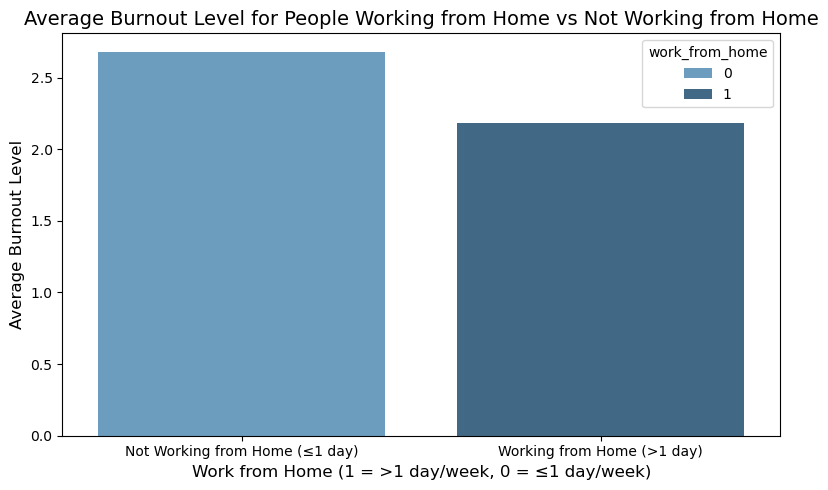

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the bar plot of mean burnout level for work_from_home vs not
plt.figure(figsize=(8, 5))
sns.barplot(
    x='work_from_home',
    y='burnout_numeric',
    data=filtered_data,
    errorbar=None,  # Fix for `ci` parameter deprecation
    hue='work_from_home',  # Assign `x` variable to `hue`
    dodge=False,  # Disable dodging since this isn't a grouped barplot
    palette='Blues_d'  # Keep the palette setting
)

# Set labels and title
plt.xlabel('Work from Home (1 = >1 day/week, 0 = ≤1 day/week)', fontsize=12)
plt.ylabel('Average Burnout Level', fontsize=12)
plt.title('Average Burnout Level for People Working from Home vs Not Working from Home', fontsize=14)
plt.xticks([0, 1], ['Not Working from Home (≤1 day)', 'Working from Home (>1 day)'], rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


In [8]:
data['WORK_shift_days_from_home_num'].value_counts()

WORK_shift_days_from_home_num
0.0    124
4.0     57
2.0     57
5.0     55
1.0     43
3.0     38
7.0     29
6.0     10
Name: count, dtype: int64

# IMPORTANT!

## Days 6 and 7 have relatively low sample sizes and aren't very representative since people working 6-7 days a week will be burnt out anyway. In an effort to reduce outliers, the below code just reproduces everything you've seen above, but only with Days 0-5.

Chi-square Statistic: 123.92812656123566
P-value: 2.2264770835596663e-13
Degrees of Freedom: 30
Expected Frequencies: 
[[20.21714286 27.84       21.21142857 13.92       10.27428571 11.26857143
  11.26857143]
 [ 7.14571429  9.84        7.49714286  4.92        3.63142857  3.98285714
   3.98285714]
 [ 8.88857143 12.24        9.32571429  6.12        4.51714286  4.95428571
   4.95428571]
 [ 5.92571429  8.16        6.21714286  4.08        3.01142857  3.30285714
   3.30285714]
 [ 9.76       13.44       10.24        6.72        4.96        5.44
   5.44      ]
 [ 9.06285714 12.48        9.50857143  6.24        4.60571429  5.05142857
   5.05142857]]
                            OLS Regression Results                            
Dep. Variable:        burnout_numeric   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     5.583
Date:                Wed, 27 Nov 202

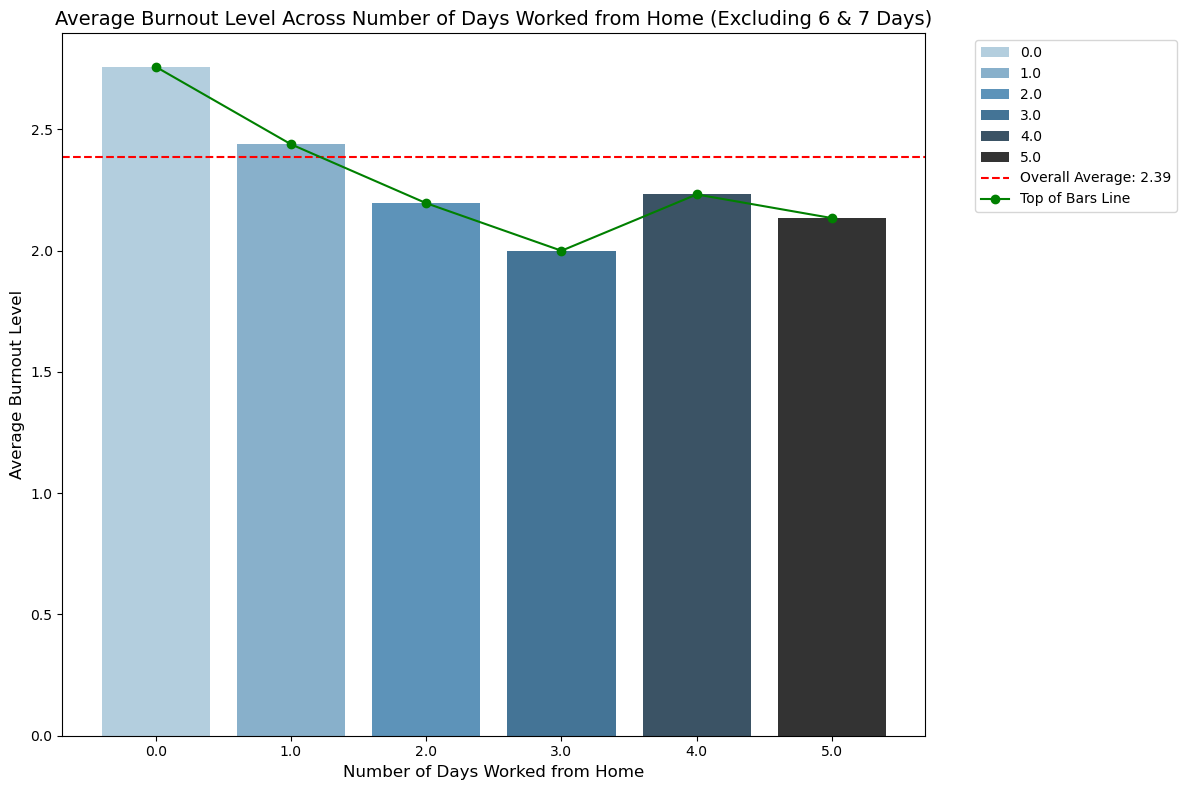

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# Assuming `filtered_data` is the DataFrame containing the relevant data

# Exclude responses where WORK_shift_days_from_home_num is 6 or 7
filtered_data = filtered_data[~filtered_data['WORK_shift_days_from_home_num'].isin([6, 7])]

# Map burnout levels to numeric values
burnout_map = {
    'Never': 0,
    'A few times a year or less': 1,
    'Once a month or less': 2,
    'A few times a month': 3,
    'Once a week': 4,
    'A few times a week': 5,
    'Every day': 6
}

# Apply the mapping to create a numeric burnout variable
filtered_data['burnout_numeric'] = filtered_data['WELLNESS_maslach_burnout_burned_out'].map(burnout_map)

### Chi-Square Test ###

# Create a contingency table for the chi-square test
contingency_table = pd.crosstab(filtered_data['WORK_shift_days_from_home_num'], filtered_data['burnout_numeric'])

# Perform the Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the result
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

### OLS Regression ###

# Perform OLS regression (work from home as indicator variable, burnout as numeric)
X = filtered_data['WORK_shift_days_from_home_num']
X = sm.add_constant(X)  # Add a constant for the intercept
y = filtered_data['burnout_numeric']

model = sm.OLS(y, X).fit()
print(model.summary())

### Visualization ###

# Plotting the bar plot of average burnout level across different work shift days from home
plt.figure(figsize=(12, 8))  # Increase the figure size for a larger plot
sns.barplot(
    x='WORK_shift_days_from_home_num', 
    y='burnout_numeric', 
    data=filtered_data,
    hue='WORK_shift_days_from_home_num',
    palette='Blues_d', 
    errorbar=None  # No confidence interval to keep it clean
)

# Add a horizontal line for the overall average burnout level
overall_average_burnout = filtered_data['burnout_numeric'].mean()
plt.axhline(overall_average_burnout, color='red', linestyle='--', label=f'Overall Average: {overall_average_burnout:.2f}')

# Get the top of each bar (height of the bars)
bar_heights = plt.gca().patches
bar_centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_heights]  # x positions of the bars

# Extract the height of each bar (the average burnout level for each work shift day)
bar_values = [bar.get_height() for bar in bar_heights]

# Plot the line through the tops of the bars (only for days 0 to 5)
valid_x = bar_centers[:6]  # Limit x values to the first 6 bars (0 to 5)
valid_y = bar_values[:6]   # Limit y values to the first 6 bars' heights

# Plot the line through the tops of the bars
plt.plot(valid_x, valid_y, color='green', marker='o', linestyle='-', label='Top of Bars Line')

# Set labels and title
plt.xlabel('Number of Days Worked from Home', fontsize=12)
plt.ylabel('Average Burnout Level', fontsize=12)
plt.title('Average Burnout Level Across Number of Days Worked from Home (Excluding 6 & 7 Days)', fontsize=14)

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


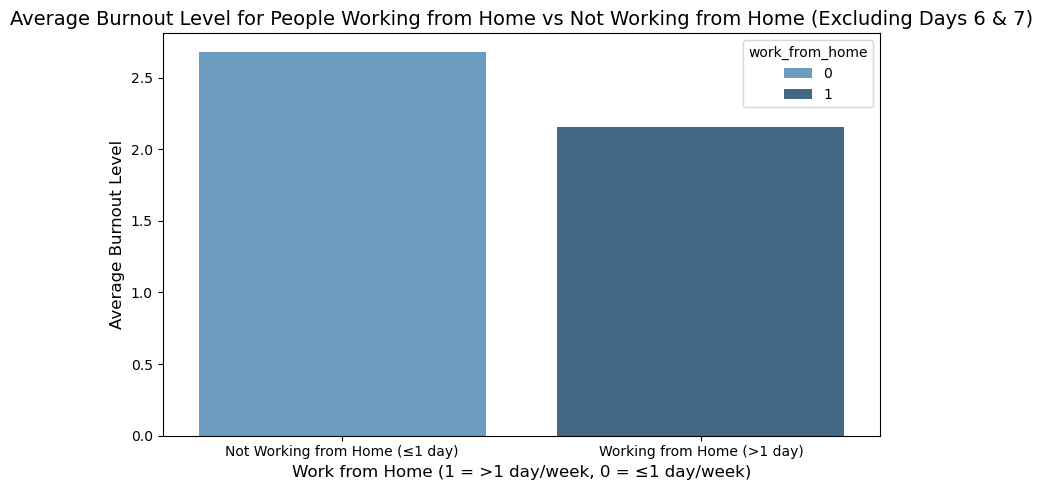

In [10]:
# Filter out days 6 and 7
filtered_data = filtered_data[~filtered_data['WORK_shift_days_from_home_num'].isin([6, 7])]

# Recalculate the work_from_home indicator variable
filtered_data['work_from_home'] = (filtered_data['WORK_shift_days_from_home_num'] > 1).astype(int)

# Plotting the bar plot of mean burnout level for work_from_home vs not
plt.figure(figsize=(8, 5))
sns.barplot(
    x='work_from_home',
    y='burnout_numeric',
    data=filtered_data,
    hue='work_from_home',
    palette='Blues_d',
    errorbar=None  # No confidence interval to keep it clean
)

# Set labels and title
plt.xlabel('Work from Home (1 = >1 day/week, 0 = ≤1 day/week)', fontsize=12)
plt.ylabel('Average Burnout Level', fontsize=12)
plt.title('Average Burnout Level for People Working from Home vs Not Working from Home (Excluding Days 6 & 7)', fontsize=14)
plt.xticks([0, 1], ['Not Working from Home (≤1 day)', 'Working from Home (>1 day)'], rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


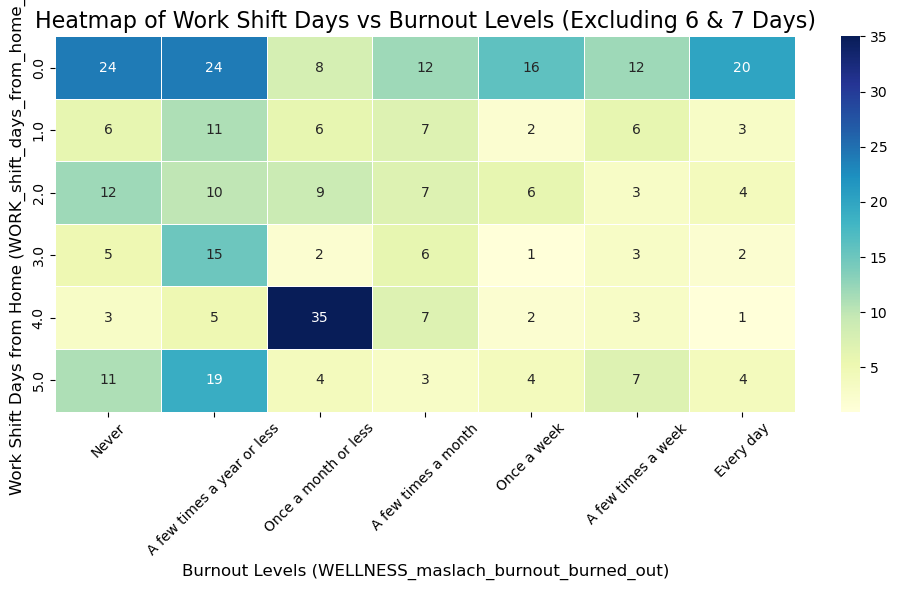

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out days 6 and 7
filtered_data = filtered_data[~filtered_data['WORK_shift_days_from_home_num'].isin([6, 7])]

# Recalculate the contingency table
contingency_table = pd.crosstab(
    filtered_data['WORK_shift_days_from_home_num'],
    filtered_data['WELLNESS_maslach_burnout_burned_out']
)

# Ensure burnout categories are ordered properly
contingency_table = contingency_table[[
    'Never', 
    'A few times a year or less', 
    'Once a month or less', 
    'A few times a month', 
    'Once a week', 
    'A few times a week', 
    'Every day'
]]

# Heatmap visualization
plt.figure(figsize=(10, 6))
sns.heatmap(
    contingency_table,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar=True,
    linewidths=.5
)
plt.title("Heatmap of Work Shift Days vs Burnout Levels (Excluding 6 & 7 Days)", fontsize=16)
plt.xlabel("Burnout Levels (WELLNESS_maslach_burnout_burned_out)", fontsize=12)
plt.ylabel("Work Shift Days from Home (WORK_shift_days_from_home_num)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


___


In [12]:
data['WORK_shift_length'].value_counts()

WORK_shift_length
8.0     107
3.0      56
7.0      44
6.0      32
5.0      28
4.0      28
9.0      23
2.0      22
10.0     15
0.0      12
12.0     12
24.0      5
1.0       5
16.0      4
14.0      3
15.0      1
20.0      1
18.0      1
11.0      1
Name: count, dtype: int64

___

## Updated MLR:

In [13]:
# Display numeric variables in a clean table format
numeric_columns = data.select_dtypes(include=['number']).columns

# Create a DataFrame to show the numeric variables with additional info
numeric_df = pd.DataFrame(numeric_columns, columns=['Numeric Variables'])
print(numeric_df)


                                Numeric Variables
0                              UNIQUE_num_records
1                                        DEMO_age
2                      WELLNESS_life_satisfaction
3                   GEO_housing_live_with_partner
4                  GEO_housing_live_with_children
..                                            ...
255      PSYCH_big_five_inventory_agreeable_score
256  PSYCH_big_five_inventory_conscientious_score
257    PSYCH_big_five_inventory_extraverted_score
258       PSYCH_big_five_inventory_neurotic_score
259           PSYCH_big_five_inventory_open_score

[260 rows x 1 columns]


In [81]:
# Get the list of numeric variables
numeric_columns = data.select_dtypes(include=['number']).columns.tolist()

# Example: Search for numeric variables containing the term 'work'
search_term = 'sleep'
matching_columns = [col for col in numeric_columns if search_term.lower() in col.lower()]

# Display the matching columns
print(f"Numeric variables containing '{search_term}':", matching_columns)


Numeric variables containing 'sleep': ['LIFESTYLE_time_use_priorities_sleep_actual', 'LIFESTYLE_time_use_priorities_sleep_desired', 'BELIEFS_rank_sleep']


In [15]:
data['CONNECTION_coworkers_interact_shift'].unique()

array([nan,  8.,  1.,  3.,  6.,  5.,  2., 12.,  0., 10., 25.,  4., 20.,
        7.,  9., 14., 48., 17., 30., 34., 40., 15., 23., 16., 41., 11.,
       50., 26., 13.])

In [82]:
LIFESTYLE_time_use_priorities_sleep_actual

array([nan,  2.,  1.,  6.,  8.,  7.,  4., 11.,  3.,  5., 10., 13.,  9.,
       12.])

In [17]:
data['LIFESTYLE_time_use_priorities_sleep_actual'].unique()

array([nan,  2.,  1.,  6.,  8.,  7.,  4., 11.,  3.,  5., 10., 13.,  9.,
       12.])

In [149]:
# Step 1: Filter and clean the data, ensuring a copy
filtered_data = data[['WELLNESS_maslach_burnout_accomplishment_subscale_score', 
                      'CONNECTION_social_media_time_per_day',
                     'LIFESTYLE_time_use_priorities_hobbies_actual']].copy()

# Step 2: Fill missing values for each column
filtered_data['WELLNESS_maslach_burnout_accomplishment_subscale_score'] = \
    filtered_data['WELLNESS_maslach_burnout_accomplishment_subscale_score'].fillna(
        filtered_data['WELLNESS_maslach_burnout_accomplishment_subscale_score'].median())


# Add 'LIFESTYLE_time_use_priorities_hobbies_actual' to the filtered data
filtered_data['LIFESTYLE_time_use_priorities_hobbies_actual'] = \
    data['LIFESTYLE_time_use_priorities_hobbies_actual']

# filtered_data['WORK_hours_per_week'] = \
#     data['WORK_hours_per_week']

# # Fill missing values with the median
# filtered_data['WORK_hours_per_week'] = \
#     filtered_data['WORK_hours_per_week'].fillna(
#         filtered_data['WORK_hours_per_week'].median())

filtered_data['LIFESTYLE_time_use_priorities_sleep_actual'] = \
    (data['LIFESTYLE_time_use_priorities_sleep_actual'] <= 4).astype(int)

# Fill missing values with the median
filtered_data['LIFESTYLE_time_use_priorities_sleep_actual'] = \
    filtered_data['LIFESTYLE_time_use_priorities_sleep_actual'].fillna(
        filtered_data['LIFESTYLE_time_use_priorities_sleep_actual'].mode())


# Fill missing values with the median
filtered_data['LIFESTYLE_time_use_priorities_hobbies_actual'] = \
    filtered_data['LIFESTYLE_time_use_priorities_hobbies_actual'].fillna(
        filtered_data['LIFESTYLE_time_use_priorities_hobbies_actual'].median())



# Add 'WORK_shift_days_from_home_num' to the filtered data
filtered_data['WORK_shift_days_from_home_num'] = data['WORK_shift_days_from_home_num']

filtered_data = filtered_data[~filtered_data['WORK_shift_days_from_home_num'].isin([6, 7])]

# Fill missing values with the mean
filtered_data['WORK_shift_days_from_home_num'] = \
    filtered_data['WORK_shift_days_from_home_num'].fillna(
        filtered_data['WORK_shift_days_from_home_num'].median())

# Optional: Create an indicator variable for working from home
# >1 day from home = 1 (work from home), <=1 day from home = 0 (no/limited work from home)
filtered_data['work_from_home_indicator'] = (
    filtered_data['WORK_shift_days_from_home_num'] >= 1
).astype(int)


filtered_data['hobbies_indicator'] = (filtered_data['LIFESTYLE_time_use_priorities_hobbies_actual'] <= 4).astype(int)

# Step 5: Prepare predictors (X) and outcome (y)
X = filtered_data[['LIFESTYLE_time_use_priorities_sleep_actual', 'work_from_home_indicator', 'hobbies_indicator']]  # Predictors
X = sm.add_constant(X)  # Add constant for intercept
y = filtered_data['WELLNESS_maslach_burnout_accomplishment_subscale_score']  # Outcome variable

# Step 6: Fit the model
model = sm.OLS(y, X).fit()

# Display the regression summary
print(model.summary())


                                              OLS Regression Results                                              
Dep. Variable:     WELLNESS_maslach_burnout_accomplishment_subscale_score   R-squared:                       0.013
Model:                                                                OLS   Adj. R-squared:                  0.012
Method:                                                     Least Squares   F-statistic:                     42.12
Date:                                                    Wed, 27 Nov 2024   Prob (F-statistic):           4.85e-27
Time:                                                            18:08:21   Log-Likelihood:                -23030.
No. Observations:                                                    9979   AIC:                         4.607e+04
Df Residuals:                                                        9975   BIC:                         4.610e+04
Df Model:                                                               3       

In [150]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Assuming filtered_data is already loaded and cleaned

# Step 1: Prepare predictors (X) and outcome (y)
X = filtered_data[['LIFESTYLE_time_use_priorities_sleep_actual', 'work_from_home_indicator', 'hobbies_indicator']]  # Predictors
X = sm.add_constant(X)  # Add constant for intercept
y = filtered_data['WELLNESS_maslach_burnout_accomplishment_subscale_score']  # Outcome variable


In [170]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# Assuming `filtered_data` is the DataFrame containing the relevant data

# Exclude responses where WORK_shift_days_from_home_num is 6 or 7
data = data[~data['WORK_shift_days_from_home_num'].isin([6, 7])]

# Map burnout levels to numeric values
burnout_map = {
    'Never': 0,
    'A few times a year or less': 1,
    'Once a month or less': 2,
    'A few times a month': 3,
    'Once a week': 4,
    'A few times a week': 5,
    'Every day': 6
}

# Apply the mapping to create a numeric burnout variable
data['burnout_numeric'] = data['WELLNESS_maslach_burnout_burned_out'].map(burnout_map)

### Chi-Square Test ###

# Create a contingency table for the chi-square test
contingency_table = pd.crosstab(data['WORK_shift_days_from_home_num'], data['burnout_numeric'])

# Perform the Chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the result
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")


Chi-square Statistic: 123.92812656123566
P-value: 2.2264770835596663e-13
Degrees of Freedom: 30
Expected Frequencies: 
[[20.21714286 27.84       21.21142857 13.92       10.27428571 11.26857143
  11.26857143]
 [ 7.14571429  9.84        7.49714286  4.92        3.63142857  3.98285714
   3.98285714]
 [ 8.88857143 12.24        9.32571429  6.12        4.51714286  4.95428571
   4.95428571]
 [ 5.92571429  8.16        6.21714286  4.08        3.01142857  3.30285714
   3.30285714]
 [ 9.76       13.44       10.24        6.72        4.96        5.44
   5.44      ]
 [ 9.06285714 12.48        9.50857143  6.24        4.60571429  5.05142857
   5.05142857]]


In [151]:
filtered_data.shape

(9979, 7)

## Visualizations

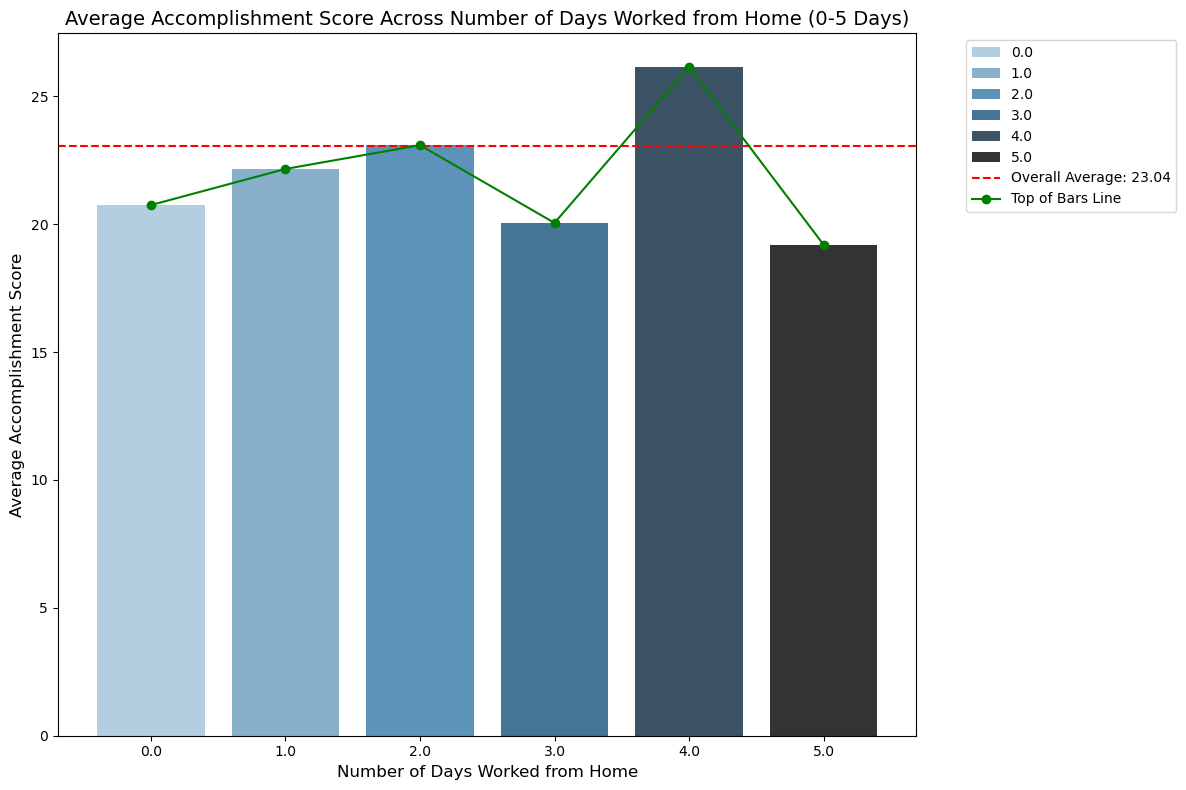

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the bar plot of average accomplishment score across different work shift days from home (0-5)
plt.figure(figsize=(12, 8))  # Increase the figure size for a larger plot
sns.barplot(
    x='WORK_shift_days_from_home_num', 
    y='WELLNESS_maslach_burnout_accomplishment_subscale_score', 
    data=filtered_data[filtered_data['WORK_shift_days_from_home_num'] <= 5],  # Filter for 0-5 days worked from home
    hue='WORK_shift_days_from_home_num',  # Color by the number of days worked from home
    palette='Blues_d', 
    errorbar=None  # No confidence interval to keep it clean
)

# Add a horizontal line for the overall average accomplishment score
overall_average_accomplishment = filtered_data['WELLNESS_maslach_burnout_accomplishment_subscale_score'].mean()
plt.axhline(overall_average_accomplishment, color='red', linestyle='--', label=f'Overall Average: {overall_average_accomplishment:.2f}')

# Get the top of each bar (height of the bars)
bar_heights = plt.gca().patches
bar_centers = [bar.get_x() + bar.get_width() / 2 for bar in bar_heights]  # x positions of the bars

# Extract the height of each bar (the average accomplishment score for each work shift day)
bar_values = [bar.get_height() for bar in bar_heights]

# Plot the line through the tops of the bars
valid_x = bar_centers[:6]  # Limit x values to the first 6 bars (0 to 5)
valid_y = bar_values[:6]   # Limit y values to the first 6 bars' heights

# Plot the line through the tops of the bars
plt.plot(valid_x, valid_y, color='green', marker='o', linestyle='-', label='Top of Bars Line')

# Set labels and title
plt.xlabel('Number of Days Worked from Home', fontsize=12)
plt.ylabel('Average Accomplishment Score', fontsize=12)
plt.title('Average Accomplishment Score Across Number of Days Worked from Home (0-5 Days)', fontsize=14)

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


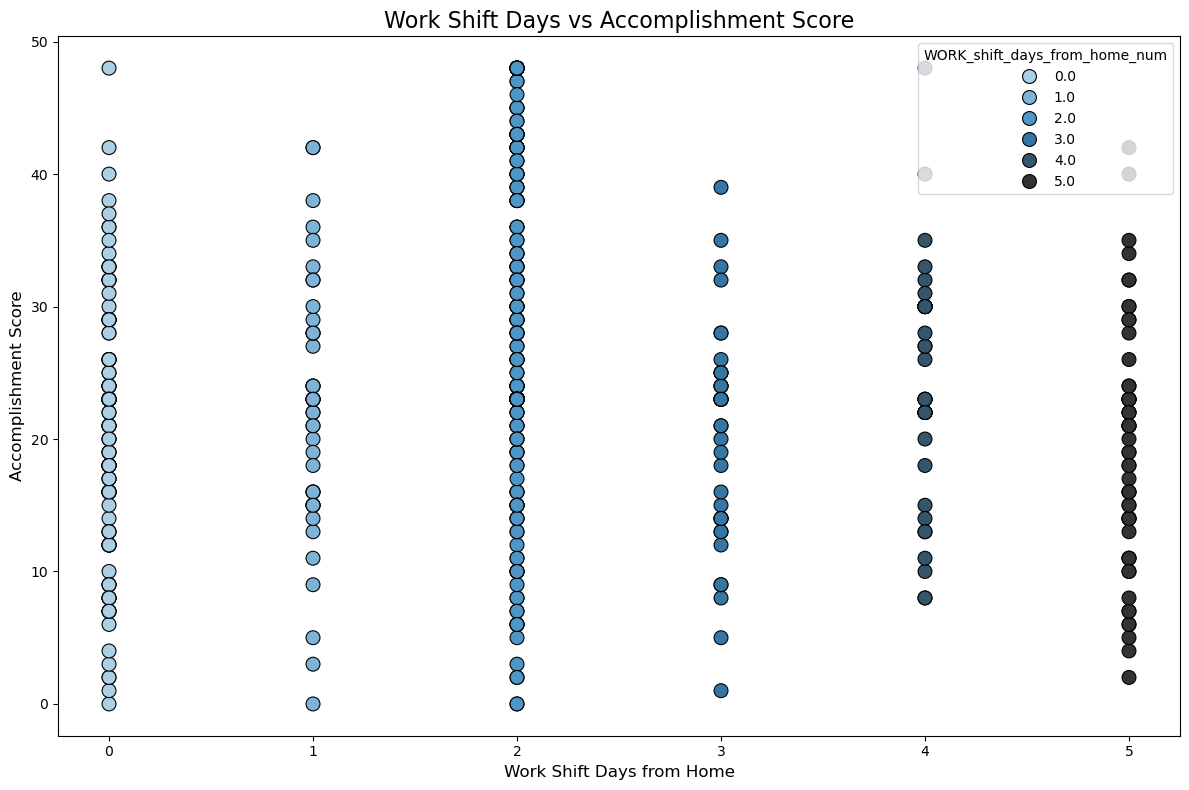

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of work shift days vs. accomplishment score
plt.figure(figsize=(12, 8))
sns.scatterplot(data=filtered_data, x='WORK_shift_days_from_home_num', 
                y='WELLNESS_maslach_burnout_accomplishment_subscale_score', 
                hue='WORK_shift_days_from_home_num', palette='Blues_d', s=100, edgecolor='black')

# Titles and labels
plt.title('Work Shift Days vs Accomplishment Score', fontsize=16)
plt.xlabel('Work Shift Days from Home', fontsize=12)
plt.ylabel('Accomplishment Score', fontsize=12)
plt.tight_layout()
plt.show()


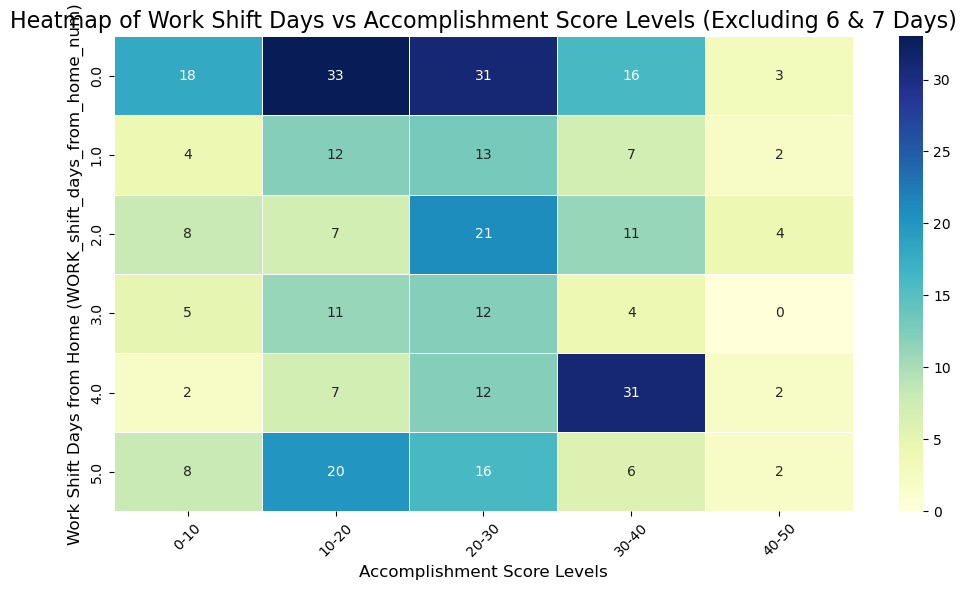

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'filtered_data' is already loaded

# Filter out days 6 and 7
data = data[~data['WORK_shift_days_from_home_num'].isin([6, 7])]

# Bin the continuous accomplishment score into categories (e.g., 0-10, 10-20, etc.)
bins = [0, 10, 20, 30, 40, 50]  # Adjust these bins as necessary
labels = ['0-10', '10-20', '20-30', '30-40', '40-50']
data['accomplishment_binned'] = pd.cut(data['WELLNESS_maslach_burnout_accomplishment_subscale_score'], 
                                                bins=bins, labels=labels, right=False)

# Recalculate the contingency table
contingency_table = pd.crosstab(
    data['WORK_shift_days_from_home_num'],
    data['accomplishment_binned']
)

# Heatmap visualization
plt.figure(figsize=(10, 6))
sns.heatmap(
    contingency_table,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    cbar=True,
    linewidths=.5
)
plt.title("Heatmap of Work Shift Days vs Accomplishment Score Levels (Excluding 6 & 7 Days)", fontsize=16)
plt.xlabel("Accomplishment Score Levels", fontsize=12)
plt.ylabel("Work Shift Days from Home (WORK_shift_days_from_home_num)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_70/1983037204.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




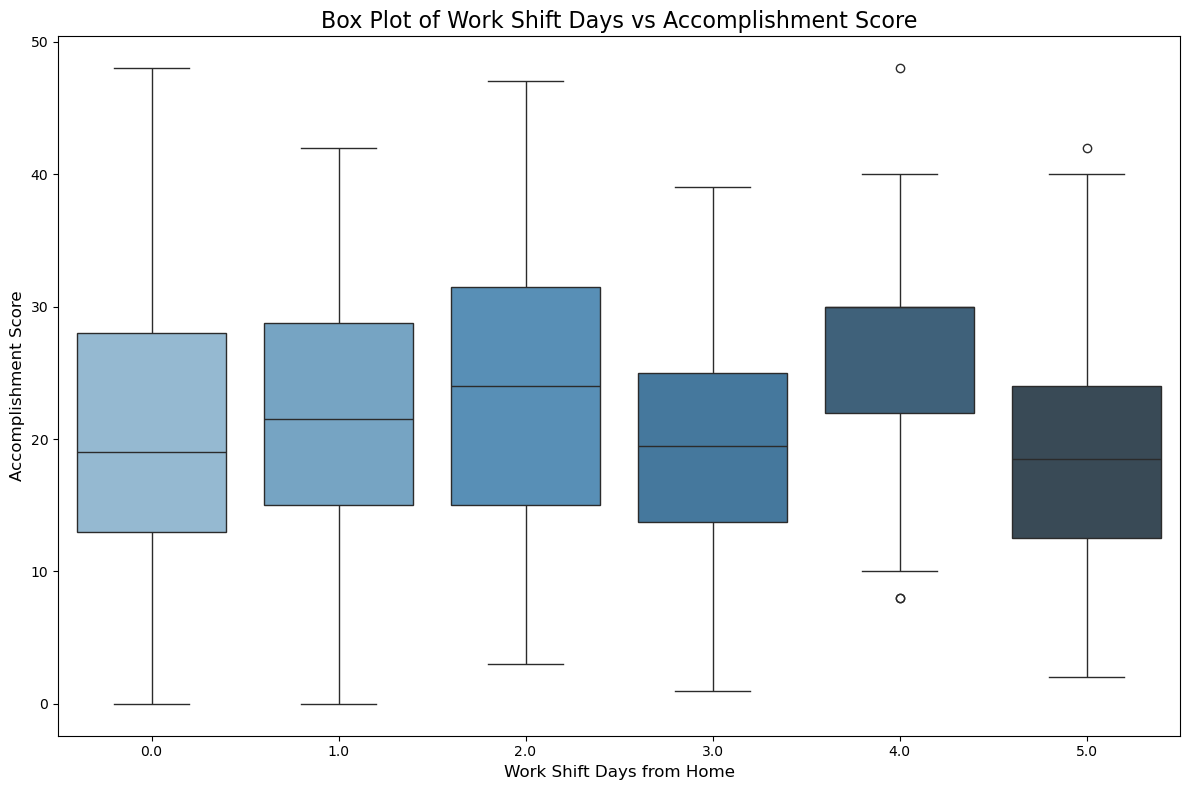

In [162]:
# Box plot of work shift days vs. accomplishment score
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='WORK_shift_days_from_home_num', 
            y='WELLNESS_maslach_burnout_accomplishment_subscale_score', 
            palette='Blues_d')

# Titles and labels
plt.title('Box Plot of Work Shift Days vs Accomplishment Score', fontsize=16)
plt.xlabel('Work Shift Days from Home', fontsize=12)
plt.ylabel('Accomplishment Score', fontsize=12)
plt.tight_layout()
plt.show()


___

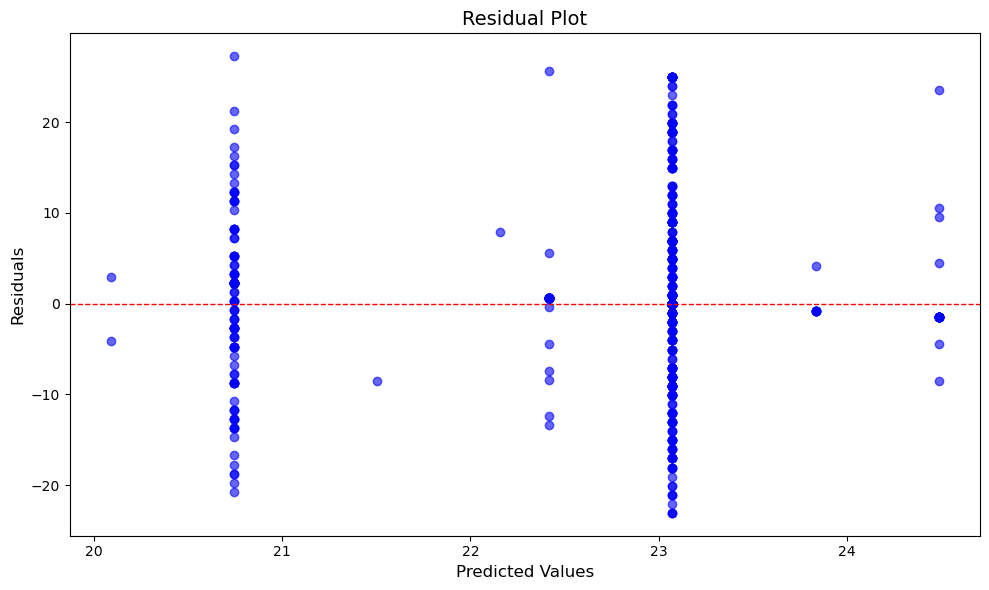

In [164]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Step 1: Prepare predictors (X) and outcome (y)
X = filtered_data[['LIFESTYLE_time_use_priorities_sleep_actual', 'work_from_home_indicator', 'hobbies_indicator']]  # Predictors
X = sm.add_constant(X)  # Add constant for intercept
y = filtered_data['WELLNESS_maslach_burnout_accomplishment_subscale_score']  # Outcome variable

# Step 2: Fit the model using OLS
model = sm.OLS(y, X).fit()

# Step 3: Get predicted values (fitted values) and residuals
y_pred = model.fittedvalues
residuals = y - y_pred

# Step 4: Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Plot", fontsize=14)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()


In [156]:
filtered_data['WELLNESS_maslach_burnout_accomplishment_subscale_score'].unique()

array([23., 12., 48., 45., 22., 21.,  4., 17., 36., 10., 33., 14.,  7.,
       32.,  5.,  0., 47., 43., 24., 15., 29.,  1., 30.,  8.,  6., 27.,
       26., 18., 11., 19., 28., 16., 42., 39., 20., 25.,  3., 40., 13.,
       38., 34., 44.,  2., 35., 31., 46.,  9., 41., 37.])